# Abstract

The objective is to implement a reinforcement learning algorithm that combines Q-Learning with deep neural networks (DQN) to let RL work for complex, high-dimensional environments, like video games from openAI gym. Here we apply a DQN network and establish a baseline performance, measure the effect of the hyperparameters and see how well the RL program works for the environment.

## Q Learning

Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.

## What's Q in Q Learning?

The 'Q' in q-learning stands for quality. Quality in this case represents how useful a given action is in gaining some future reward.

## Deep Q-Learning

Q-Learning is a simple but a powerful algorithm to teach our agent to extract maximum reward thereby teaching the agent exactly which action to perform.

Consider an environment of 10,000 states and 1,000 actions per state. This would create a table of 10 million cells. The amount of memory required to save and update the table would increase as the number of states increase. The amount of time required to explore each state to create the Q-Table would be unrealistic.

In deep Q-learning, we use a neural network to approximate the Q-value function. The state is given as the input and the Q-value of all possible actions is generated as the output.

The below image gives us an overview of how Q-Learning and Deep-Q-Learning works:

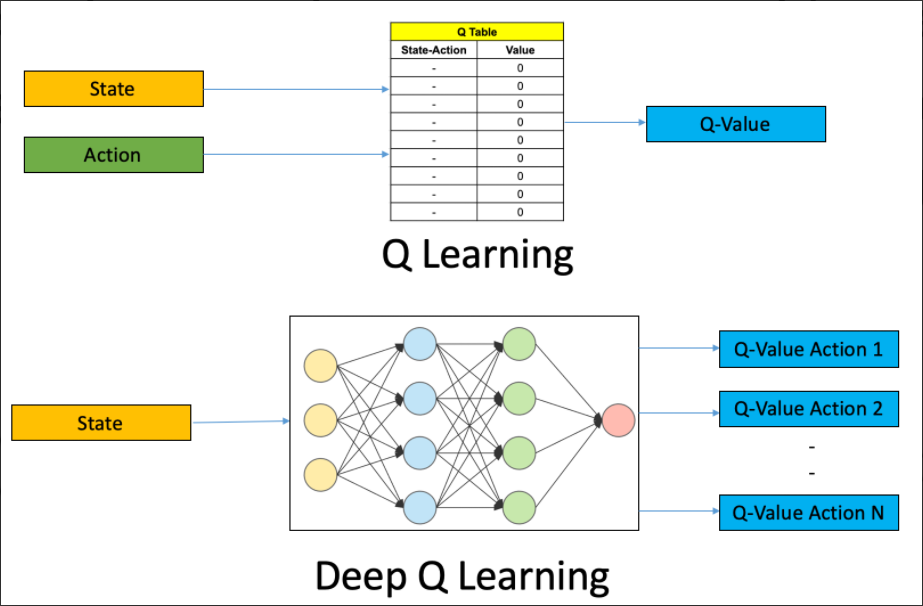

The Steps involved in DQNs are :

1. Preprocess and feed the game screen (state s) to our DQN, which will return the Q-values of all possible actions in thestate
2. Select an action using the epsilon-greedy policy. With the probability epsilon, we select a random action a and with probability 1-epsilon, we select an action that has a maximum Q-value, such as a = argmax(Q(s,a,w))
3. Perform this action in a state s and move to a new state s’ to receive a reward. This state s’ is the preprocessed image of the next game screen. We store this transition in our replay buffer as <s,a,r,s’>
4. Next, sample some random batches of transitions from the replay buffer and calculate the loss
5. It is known that: 
    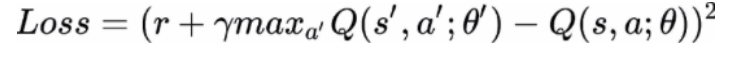

    which is just the squared difference between target Q and predicted Q

6. Perform gradient descent with respect to our actual network parameters in order to minimize this loss
7. After every C iterations, copy our actual network weights to the target network weights
8. Repeat these steps for M number of episodes

Going back to the Q-Value update equation derived from the Bellman equation, we have:

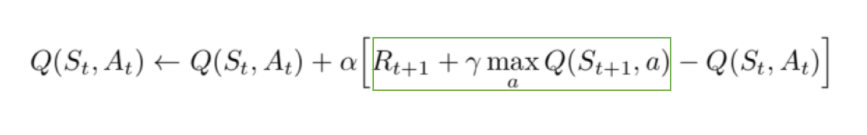

The section in green represents the target. We can argue that it is predicting its own value, but since R is the unbiased true reward, the network is going to update its gradient using backpropogation to finally converge.

## Lunar Lander-v2 Open AI Gym

OpenAI is a toolkit for developing and implementing Reinforcement Learning Algorithms. Here we look to apply DQNs to one of OpenAI's Game Environment Lunar Lander-v2. 

The Objective of the game is to train the agent(Lander) to land in the landing zone indicated between two flags. Since the environment is 2D and since the number of states and available actions in each state is a lot, we look to solve this environment using DQNs. 

The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector.

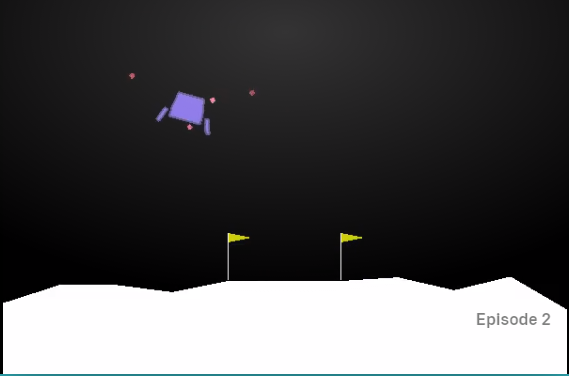

### Discrete Actions

According to Pontryagin's maximum principle it's optimal to fire engine full throttle or turn it off. That's the reason this environment is OK to have discreet actions (engine on or off).

Four Discrete Actions are available: 

1. Do Nothing
2. Fire Left Orientation Engine
3. Fire Right Orientation Engine
4. Fire Main Engine

### Points Scoring

Reward for moving from the top of the screen to the landing pad and zero speed is about 100 to 140 points.
If the lander moves away from the landing pad it loses reward.

Episode: The Episode finishes if the lander crashes or comes to rest, receiving an additional -100 or +100 points.

Everytime the one of the lander's legs makes contact with the ground is an additional 10 points. Firing the main engine is -0.3 points per frame. Firing the side engine is -0.03 points each frame. 

Solved environment is +200 points.

Fuel is infinite so an agent can learn to fly and and then land on its first attempt.




## Importing Libraries and Setting up the environment

In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.activations import relu, linear
import tensorflow as tf

In [2]:
#Testing the number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
#Setting up the Environment

env = gym.make('LunarLander-v2')
env.seed(0)
np.random.seed(0)

# Baseline Model

Here we establish a baseline model by setting the parameters as follows :

total_test_epsiodes = 500;
max_steps = 3000;
learning_rate = 0.001;
gamma = 0.99;
epsilon = 1.0;
min_epsilon = 0.01;
epsilon_decay = 0.996;


In [4]:
##Implementing the Deep Q Learning Algorithm

class DQN:  

   #Initializing the Learning Rate to implement Epsilon-Greedy Policy

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()
        
#Building the Neural Network with input layer as the Starting State 
#and Final Layer to be action_Space which determines the end of the episode

    def build_model(self):  

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model
    
 #Storing current state, action, reward and next_state in memory 
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
def train_dqn(episode):

    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        score = 0
        max_steps = 3000
        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)

        # Calculating the Average score of last 100 episodes to see if the cumulative reward score is above 200
        is_solved = np.mean(loss[-100:])
        if is_solved > 200:
            print('\n Task Completed! \n')
            break
        print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    return loss

In [ ]:
if __name__ == '__main__':

    print(env.observation_space)
    print(env.action_space)
    episodes = 500
    loss = train_dqn(episodes)
    plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()

Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Discrete(4)


C:\Users\kesha\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


episode: 0/500, score: -98.72162286018346
Average over last 100 episode: -98.72 

episode: 1/500, score: -113.91066472321309
Average over last 100 episode: -106.32 

episode: 2/500, score: -76.79132185954619
Average over last 100 episode: -96.47 

episode: 3/500, score: -765.4471726518796
Average over last 100 episode: -263.72 

episode: 4/500, score: -116.40570827891744
Average over last 100 episode: -234.26 

episode: 5/500, score: -168.68298080575445
Average over last 100 episode: -223.33 

episode: 6/500, score: -194.95153479217146
Average over last 100 episode: -219.27 

episode: 7/500, score: -66.33830155369859
Average over last 100 episode: -200.16 

episode: 8/500, score: -246.99277405855034
Average over last 100 episode: -205.36 

episode: 9/500, score: -145.06111214065163
Average over last 100 episode: -199.33 

episode: 10/500, score: -87.54040274993399
Average over last 100 episode: -189.17 

episode: 11/500, score: -420.0298514436417
Average over last 100 episode: -208.41 

In [ ]:
env.close()

### Observations

With the baseline model - the environment was solved in 160 episodes when the parameters are under optimal conditions.

The environment was considered solved when rewards accumulated exceeded 200.

## What are the states, the actions, and the size of the Q-table?

The observation space determines various attributes about the lander. Specifically, there are 8 state variables associated with the state space, as shown below:

States -

x - Coordinate of the lander;
y - Coordinate of the lander;
Vx - the horizontal velocity;
Vy - the vertical velocity;
θ - the orientation in space;
Vθ - the angular velocity;
Left leg touching the ground (Boolean);
Right leg touching the ground (Boolean);





Action Space - 

There are four discrete actions available: do nothing, fire left orientation engine, fire right orientation engine, and fire
main engine. Firing the left and right engines introduces a torque on the lander, which causes it to rotate, and makes stabilizing difficult.

## What are the rewards? Why did you choose them?

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

## How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?

### Alpha

Alpha is the learning rate which has been selected as 0.001

### Gamma 

Gamma is the discount factor. It quantifies how much importance we give for future rewards. It's also handy to approximate the noise in future rewards. Gamma varies from 0 to 1. If Gamma is closer to zero, the agent will tend to consider only immediate rewards. if Gamma is closer to one, the agent will consider future rewards with greater weight, willing to delay the reward.

Here Gamma is chosen as 0.99

In [4]:
##Implementing the Deep Q Learning Algorithm

class DQN_alpha_gamma:  

   #Initializing the Learning Rate to implement Epsilon-Greedy Policy

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .50
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.1
        self.epsilon_decay = .996
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()
        
        #Building the Neural Network with input layer as the Starting State 
#and Final Layer to be action_Space which determines the end of the episode

    def build_model(self):  

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model
    
 #Storing current state, action, reward and next_state in memory 
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
def train_dqn(episode):

    loss = []
    agent = DQN_alpha_gamma(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        score = 0
        max_steps = 3000
        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)

        # Calculating the Average score of last 100 episodes to see if the cumulative reward score is above 200
        is_solved = np.mean(loss[-100:])
        if is_solved > 200:
            print('\n Task Completed! \n')
            break
        print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    return loss

Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Discrete(4)


C:\Users\kesha\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


episode: 0/100, score: -122.94134670972947
Average over last 100 episode: -122.94 

episode: 1/100, score: -107.56947702982933
Average over last 100 episode: -115.26 

episode: 2/100, score: -160.3208457201536
Average over last 100 episode: -130.28 

episode: 3/100, score: -107.95553830987114
Average over last 100 episode: -124.70 

episode: 4/100, score: -291.00773382817283
Average over last 100 episode: -157.96 

episode: 5/100, score: -663.6442863003706
Average over last 100 episode: -242.24 

episode: 6/100, score: -240.47069746179147
Average over last 100 episode: -241.99 

episode: 7/100, score: -173.57638878691708
Average over last 100 episode: -233.44 

episode: 8/100, score: -468.53991123771067
Average over last 100 episode: -259.56 

episode: 9/100, score: -461.43956952961264
Average over last 100 episode: -279.75 

episode: 10/100, score: -2343.128142991434
Average over last 100 episode: -467.33 

episode: 11/100, score: -463.7718687318328
Average over last 100 episode: -467

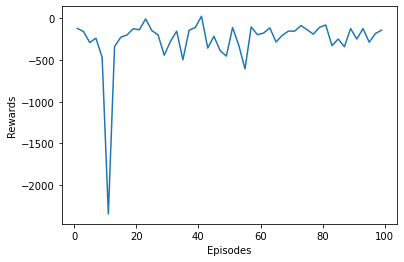

In [6]:
if __name__ == '__main__':

    print(env.observation_space)
    print(env.action_space)
    episodes = 100
    loss = train_dqn(episodes)
    plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()

In [9]:
env.close()

### Observations

Here we plugged in Gamma value = 0.5 and Alpha (Learning_rate) = 0.1

The episodes kept going with average rewards of negative 270-300 since the gamma value was considering immediate rewards and not considering future rewards as a result of the lower value along with alpha which had the value of 0.1.

With lower gamma and greater alpha values, the losses did not reduce and the agent kept exploring and crashing.

Baseline - Average rewards over 100 episodes was observed to be +27.15

With low gamma and high alpha value the average rewards over 100 episodes doesn't seem to be doing well with a score of -254.07

## How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode?

Starting Epsilon of 1 was chosen for maximum exploration. 

Epsilon Decay is the decay rate where the value decreases after an epsiode. An epsilon Decay of 0.96 was chosen as this would provide a better balance between Exploration-Exploitation.

To test different values of epsilon, the starting espilon starts 1.0 for max exploration and a faster decay rate of 0.7 to test performance of the lunar module

In [13]:
##Implementing the Deep Q Learning Algorithm

class DQN_epsilon:  

   #Initializing the Learning Rate to implement Epsilon-Greedy Policy

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .7
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()
        
        #Building the Neural Network with input layer as the Starting State 
#and Final Layer to be action_Space which determines the end of the episode

    def build_model(self):  

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model
    
 #Storing current state, action, reward and next_state in memory 
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [14]:
def train_dqn(episode):

    loss = []
    agent = DQN_epsilon(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        score = 0
        max_steps = 3000
        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)

        # Calculating the Average score of last 100 episodes to see if the cumulative reward score is above 200
        is_solved = np.mean(loss[-100:])
        if is_solved > 200:
            print('\n Task Completed! \n')
            break
        print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    return loss

Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Discrete(4)
episode: 0/100, score: -198.05192430984232
Average over last 100 episode: -198.05 

episode: 1/100, score: -233.38136421970057
Average over last 100 episode: -215.72 

episode: 2/100, score: 268.1033878830787
Average over last 100 episode: -54.44 

episode: 3/100, score: -22.2824508686746
Average over last 100 episode: -46.40 

episode: 4/100, score: -67.42374119695519
Average over last 100 episode: -50.61 

episode: 5/100, score: -304.48290012249146
Average over last 100 episode: -92.92 

episode: 6/100, score: -283.5347596494562
Average over last 100 episode: -120.15 

episode: 7/100, score: -225.57545926370216
Average over last 100 episode: -133.33 

episode: 8/100, score: -266.7885104014415
Average over last 100 episode: -148.16 

episode: 9/100, score: -114.6251942406803
Average over last 100 episode: -144.80 

episode: 10/100, score: -113.30344007816316
Average over last 1

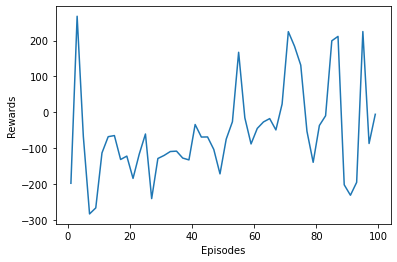

In [15]:
if __name__ == '__main__':

    print(env.observation_space)
    print(env.action_space)
    episodes = 100
    loss = train_dqn(episodes)
    plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()

In [16]:
env.close()

### Observations

Here we plugged in starting epsilon on 1.0 with an epsilon decay of 0.7

Baseline - Average rewards over 100 episodes was observed to be +27.15

Average over 100 episodes recorded - -62.28
With an e-decay rate of 0.7 which results in a faster transition from exploration to pure exploitation, the agent seems to be making progress but irregular and slow.

## Does Q-learning use value-based or policy-based iteration?

Q learning is a value-based off-policy temporal difference(TD) reinforcement learning. Off-policy means an agent follows a behaviour policy for choosing the action to reach the next state s_t+1 from state s_t. From s_t+1, it uses a policy π that is different from behaviour policy. In Q-learning, we take absolute greedy action as policy π from the next state s_t+1.

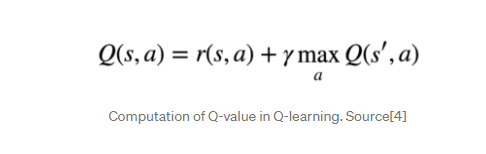

the above equation indicates how we compute the Q-value for an action a starting from state s in Q learning. It is the sum of immediate reward using a behaviour policy(ϵ-soft, ϵ-greedy or softmax) and from state s_t+1, it takes the absolute greedy action (choose the action that has maximum Q value over other actions).


## Could you use SARSA for this problem?

Since we do no encode any prior knowledge about the outside world into the agent and the state traisition function is hard to mode, SARSA can also be an approach to train the agent using an exploration policy like Epsilon-Greedy. 

##  How does SARSA differ from Q-learning? When would SARSA likely do better than Q-learning? 

Q-learning has the following advantages and disadvantages compared to SARSA:

Q-learning directly learns the optimal policy, whilst SARSA learns a near-optimal policy whilst exploring. If you want to learn an optimal policy using SARSA, then you will need to decide on a strategy to decay ϵ in ϵ-greedy action choice, which may become a fiddly hyperparameter to tune.

Q-learning (and off-policy learning in general) has higher per-sample variance than SARSA, and may suffer from problems converging as a result. This turns up as a problem when training neural networks via Q-learning.

SARSA will approach convergence allowing for possible penalties from exploratory moves, whilst Q-learning will ignore them. That makes SARSA more conservative - if there is risk of a large negative reward close to the optimal path, Q-learning will tend to trigger that reward whilst exploring, whilst SARSA will tend to avoid a dangerous optimal path and only slowly learn to use it when the exploration parameters are reduced. The classic toy problem that demonstrates this effect is called cliff walking.

In practice the last point can make a big difference if mistakes are costly - e.g. you are training a robot not in simulation, but in the real world. You may prefer a more conservative learning algorithm that avoids high risk, if there was real time and money at stake if the robot was damaged.

If your goal is to train an optimal agent in simulation, or in a low-cost and fast-iterating environment, then Q-learning is a good choice, due to the first point (learning optimal policy directly). If your agent learns online, and you care about rewards gained whilst learning, then SARSA may be a better choice.

## Explain the Q-learning algorithm.

Q-Learning is a value-based learning algorithm. Value based algorithms updates the value function based algorithms updates the value function based on an equation (Bellman equation). Where as policy-based estimates the value function with a greedy policy obtained from the last policy improvement.

Q-learning is an off-policy learner. Means it learns the value of the optimal policy independently of the agent’s actions. On the other hand, an on-policy learner learns the value of the policy being carried out by the agent, including the exploration steps and it will find a policy that is optimal, taking into account the exploration inherent in the policy.

#### Algorithm

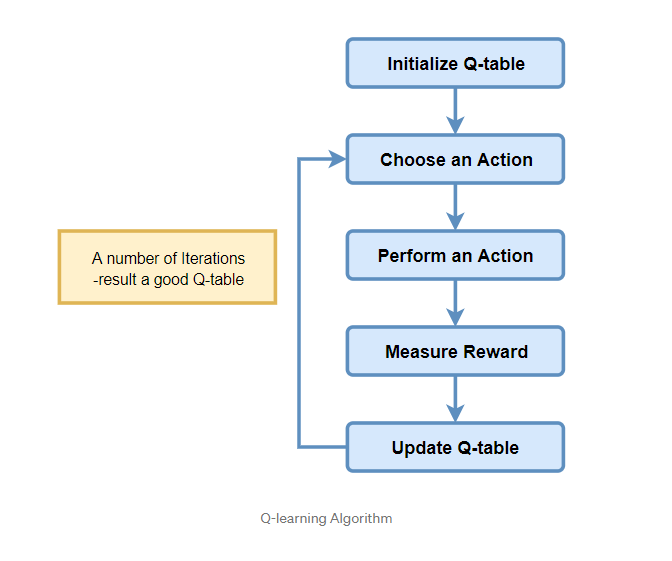

#### Step 1: Initialize the Q-Table

First the Q-table has to be built. There are n columns, where n= number of actions. There are m rows, where m= number of states.

#### Step 2 : Choose an Actiom

#### Step 3: Perform an Action

The combination of steps 2 and 3 is performed for an undefined amount of time. These steps runs until the time training is stopped, or when the training loop stopped as defined in the code.

First, an action (a) in the state (s) is chosen based on the Q-Table. Note that, as mentioned earlier, when the episode initially starts, every Q-value should be 0.

Then, update the Q-values for being at the start and moving right using the Bellman equation which is stated above.

Epsilon greedy strategy concept comes in to play here. In the beginning, the epsilon rates will be higher. The agent will explore the environment and randomly choose actions. This occurs like this logically,since the agent does not know anything about the environment. As the agent explores the environment, the epsilon rate decreases and the agent starts to exploit the environment.

During the process of exploration, the agent progressively becomes more confident in estimating the Q-values.

#### Steps 4 : Measure Reward

Now we have taken an action and observed an outcome and reward.

#### Steps 5 : Evaluate

We need to update the function Q(s,a).

This process is repeated again and again until the learning is stopped. In this way the Q-Table is been updated and the value function Q is maximized. Here the Q(state, action) returns the expected future reward of that action at that state.

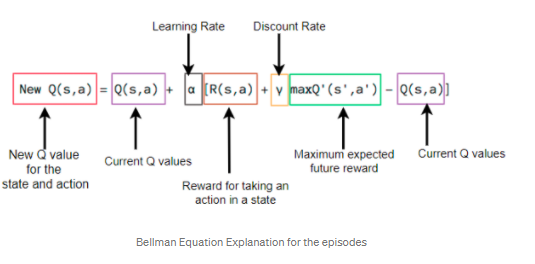


## Explain the SARSA Algorithm

The Sarsa algorithm is an On-Policy algorithm for TD-Learning. 

The major difference between it and Q-Learning, is that the maximum reward for the next state is not necessarily used for updating the Q-values. Instead, a new action, and therefore reward, is selected using the same policy that determined the original action. 

The name Sarsa actually comes from the fact that the updates are done using the quintuple Q(s, a, r, s', a'). Where: s, a are the original state and action, r is the reward observed in the following state and s', a' are the new state-action pair.



Here, the equation for SARSA depends on the current state, current action, reward obtained, next state and next action. This observation lead to the naming of the learning technique as SARSA stands for State Action Reward State Action which symbolizes the tuple (s, a, r, s’, a’).

### Pseudo Code

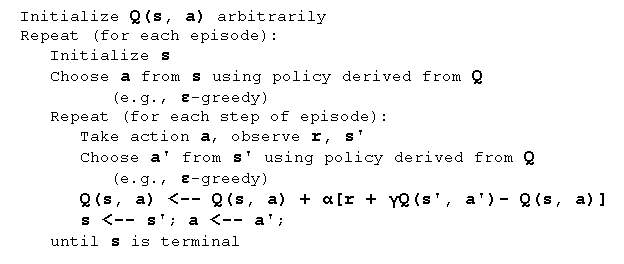

As you can see, there are two action selection steps needed, for determining the next state-action pair along with the first. The parameters  and  have the same meaning as they do in Q-Learning.




## Conclusion

Here we observed how the openAI gym's Lunar Lander Environment (Discrete) could be solved using DQN. Initialized the model and plugged in parameters with optimal values to setup the baseline model. Experimented with different values of alpha, gamma, epsilon greedy and compared it with baseline model to see how it affects performance.  

## References


1. Medium - https://towardsdatascience.com/solving-lunar-lander-openaigym-reinforcement-learning-785675066197
2. TextBook - Reinforcement Learning: An Introduction by Richard S Sutton and Andrew G.      Bartowhttp://incompleteideas.net/book/RLbook2020.pdf
3. Youtube - https://www.youtube.com/playlist?list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv
DeepLizard.com
4. GitHub - https://github.com/shivaverma/OpenAIGym/blob/master/lunar-lander/discrete/lunar_lander.py
5. OpenAI Gym Environment - https://gym.openai.com/envs/LunarLander-v2/
6. Analytics Vidhya - https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/
7. Q - learning - https://towardsdatascience.com/practical-reinforcement-learning-02-getting-started-with-q-learning-582f63e4acd9
8. Q - Learning - https://medium.com/intro-to-artificial-intelligence/q-learning-a-value-based-reinforcement-learning-algorithm-272706d835cf
9. Sarsa and Q-Learning - https://stats.stackexchange.com/questions/326788/when-to-choose-sarsa-vs-q-learning
10. SARSA - https://www.geeksforgeeks.org/sarsa-reinforcement-learning/
11. Github - https://github.com/keshav-kl/Advanced_Data_Science_and_Architecture_Info_7390/blob/main/Info_7390_Advanced_Data_Science_Mini_Project_2_Reinforcement_Learning.ipynb

Referred the above links for concepts, explanation and code. Made changes to the code wherever necessary.

## LICENSE

Copyright <2021> Keshav K L

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.